In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
from tqdm import tqdm

## Class 정의

In [2]:
class HumanSegmentation:
    def __init__(self, model_dir, model_file):
        self.model_dir = model_dir
        self.model_file = model_file
        
        self.LABEL_NAMES = [
            'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
            'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
            'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
        ]
        
    def __call__(self, img_path, label='person'):
        print('Human Segmentation start')
        
        total_iter = 6
        progress_bar = tqdm(total=total_iter)
        
        # 이미지 가져오기
        img_origin = self._readImage(img_path)
        img_origin = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
        progress_bar.update(1)
        
        # 모델 가져오기 및 이미지 분석
        model = self._readModel()
        progress_bar.update(1)
        segvalues, output = model.segmentAsPascalvoc(img_path)
        progress_bar.update(1)
        
        # colormap에 따른 이미지 분할
        index_label = self.LABEL_NAMES.index(label)
        colormap = self._colormap()
        seg_color = (colormap[index_label][1], colormap[index_label][2], colormap[index_label][0])
        img_mask = self._createImageMask(output, seg_color)
        progress_bar.update(1)
        
        # 이미지 블러처리
        #img_copy = img_origin.copy()
        img_blur = self._createBlurImage(img_origin)
        progress_bar.update(1)
        
        # 이미지 합성
        # img_mask를 이용해 mask에 해당하면 origin, 해당하지 않으면 blur 처리
        img_concat = self._concatImage(img_mask, img_origin, img_blur)
        progress_bar.update(1)
        progress_bar.close()
        
        print('Human Segmentation Finish')
        return {
            'image': img_concat,
            'img_mask': img_mask,
            'class_ids': segvalues['class_ids']
        }
    
    def _readModel(self):
        model = semantic_segmentation()
        model.load_pascalvoc_model(self.model_file)
        return model
    
    def _readImage(self, img_path):
        img = cv2.imread(img_path)
        return img
    
    def _colormap(self):
        colormap = np.zeros((256, 3), dtype = int)
        ind = np.arange(256, dtype=int)

        for shift in reversed(range(8)):
            for channel in range(3):
                colormap[:, channel] |= ((ind >> channel) & 1) << shift
            ind >>= 3
        return colormap
    
    def _createImageMask(self, output, seg_color):
        seg_map = np.all(output==seg_color, axis=-1)
        img_mask = seg_map.astype(np.uint8) * 255
        img_mask = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
        return img_mask
    
    def _createBlurImage(self, img, ksize=(13,13)):
        img_blur = cv2.blur(img, ksize)
        return img_blur
    
    def _concatImage(self, img_mask, img_origin, img_blur):
        return np.where(img_mask==255, img_origin, img_blur)

In [3]:
model_dir = '/aiffel/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

s = HumanSegmentation(model_dir, model_file)

#### 사람(혼자)

Human Segmentation start


100%|██████████| 6/6 [00:20<00:00,  3.50s/it]


Human Segmentation Finish
[ 0  9 15]


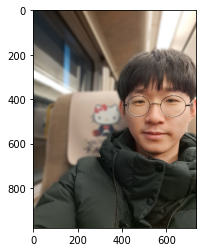

True

In [4]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/8.jpg'  

results_me = s(img_path)
img_me = results_me['image']

print(results_me['class_ids'])
plt.imshow(img_me)
plt.show()

img_me = cv2.cvtColor(img_me, cv2.COLOR_BGR2RGB)
cv2.imwrite('images/seg_me.jpg', cv2.cvtColor(img_me, cv2.COLOR_BGR2RGB))

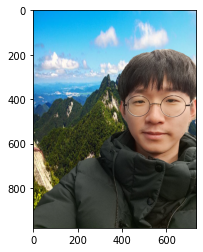

In [5]:
# 크로마키 배경
img_back = cv2.imread('images/mountain.png')
img_back = cv2.resize(img_back, (img_me.shape[1], img_me.shape[0]))

img_concat = np.where(results_me['img_mask'] == 255, img_me, img_back)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 사람(단체) 
- 출처 : [링크](https://flexible.img.hani.co.kr/flexible/normal/970/697/imgdb/original/2020/0606/1615914178841343.jpg)

Human Segmentation start


100%|██████████| 6/6 [00:30<00:00,  5.03s/it]


Human Segmentation Finish
[ 0 12 15]


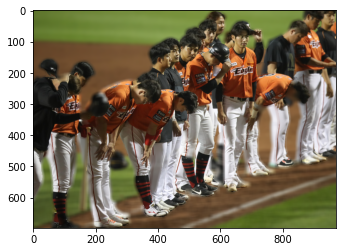

True

In [6]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/hanwha.jpg'  

results = s(img_path)
img_hanwha = results['image']

print(results['class_ids'])
plt.imshow(img_hanwha)
plt.show()

cv2.imwrite('images/seg_hanwha.jpg', cv2.cvtColor(img_hanwha, cv2.COLOR_BGR2RGB))

#### 고양이(단일)
- 출처 : [링크](https://ko.wikipedia.org/wiki/%EC%95%BC%EC%83%9D%ED%99%94%EB%90%9C_%EA%B3%A0%EC%96%91%EC%9D%B4#/media/%ED%8C%8C%EC%9D%BC:Stray_cat_at_Castillo_San_Felipe_del_Morro,_Puerto_Rico_(cropped).jpg)

Human Segmentation start


100%|██████████| 6/6 [00:20<00:00,  3.36s/it]


Human Segmentation Finish
[0 8]


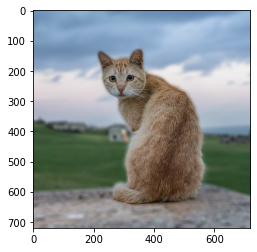

True

In [7]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'

results = s(img_path, label='cat')
img_cat = results['image']

print(results['class_ids'])
plt.imshow(img_cat)
plt.show()

cv2.imwrite('images/seg_cat.jpg', cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB))

### 문제점
- 객체가 하나면서 구분이 쉬운건 생각보다 괜찮게 처리됨
- 하지만 경계선에서 처리가 아쉬운 부분이 있음
    - 배경과 경계선이 확실히 구분되면서 생기는 부자연스러움도 존재하는듯
- 단체 사진(한화)에서 Segmentation이 불안정하게 처리됨
    - 같은 label들의 경계처리에서 모호해지는 현상이 있는 것 같다. 

![](./images/seg_hanwha_res.png)

### 피사계 심도
- 사진에서 초점이 맞은 것으로 인식되는 범위
- 초점면을 중심으로 서서히 흐려지는데 초점이 맞은 범위가 피사계 심도


### 해결방법
- 3D Depth 카메라를 활용한다면 피사체의 심도를 측정하여 3D로 입체적 인식을 해서 보다 정확한 인식이 가능하다.
    - 아이폰의 Face id가 가장 좋은 예시라고 생각한다. 
    - 타사의 Face 잠금화면은 이미지로 손쉽게 뚫리는 문제로 다른 방법(지문 등)을 채택
    - 하지만 아이폰의 경우, TrueDepth 카메라 시스템을 통해 정확히 얼굴을 인식(이미지에 있는 얼굴은 미인식)
- cv2.GaussianBlur() [link](https://dream-and-develop.tistory.com/308)
    - 위에서 생각한 배경과 경계선이 확실히 구분되면서 생기는 부자연스러움을 해결할 코드
    - 가우시안 분포(Gaussian Distribution) 함수를 근사하여 생성한 필터 마스크를 사용하는 필터링 기법으로, 평균값 필터보다 자연스러운 블러링 결과를 생성
- (개인적 생각) 다양한 모델들 활용 후 가장 분할을 잘 한 모델 선택 또는 앙상블 형태로 활용
    - 다양한 모델을 활용하여 가장 분할이 잘된 모델을 활용하는 것도 하나의 방법이라 생각
    - 또한 다양한 모델을 앙상블 형태로 활용하면 보다 정확성이 높아질 것이라 생각
    - 대신 비용이 많이 든다는 단점이 존재

### 회고
- 이번 코드는 class로 만들어서 시도해봄
    - 현업에서는 method, class를 자주 활용할 것이라 생각
    - 코드를 다시 method, class의 형태로 리팩토링하면서 손에 익도록 하자
- GaussianBlur를 이용하여 mask부분의 경계선을 부드럽게 풀어주는 방법을 한 번 사용해보고 코드로 남겨보자
- Semantic Segmentation의 metric을 찾아보고, 앙상블로 활용할 수 있는지 좀 더 검색해보자